In [1]:
%load_ext autoreload
import sys
sys.path.append('../')

import os
import sys
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d
import pickle
import csv

import config
import H2
import darkhistory.physics as phys
import darkhistory.history.tla as tla

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/H2_output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/H2_figs/'
no_DM = pickle.load(open("/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_hyrec_comparison_runs/phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p", "rb"))

# Constraints to plot

In [2]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

swave_phot_1506 = np.array([
    [0.000005107669781037991, 2.3082000871810148e-33],
    [0.000014782955623497685, 8.359026241662246e-33],
    [0.00004200898370448001, 2.4167600481593093e-32],
    [0.00010892693373180507, 7.215782483721092e-32],
    [0.00024844225597333896, 2.4503129589805065e-31],
    [0.0005666509873957798, 1.0092343322300749e-30],
    [0.0010760445166109074, 3.013296840132008e-30],
    [0.001830625339196213, 4.578030088746348e-30],
    [0.0032306046930394017, 4.292739463668156e-30],
    [0.005298316906283713, 4.578030088746348e-30],
    [0.009180465893423178, 6.315375843601291e-30],
    [0.014251026703030021, 8.712037988563021e-30],
    [0.028072162039411815, 1.6054205667926048e-29],
    [0.09407512435245924, 5.451637197075143e-29],
    [0.17221630642764663, 1.0713715750403383e-28],
    [0.4632148708747269, 3.7570787607421614e-28],
    [1.1368493498968348, 1.3175298974950191e-27],
    [2.081145226769892, 2.673903369909142e-27],
    [5.01493434885705, 5.604062807734701e-27]
])
swave_phot_interp = interp1d(swave_phot_1506[:,0]*1e9, swave_phot_1506[:,1], fill_value='extrapolate')

swave_elec_1506 = np.array([
    [0.000526605524816478, 6.860051014132962e-31],
    [0.0011162085840864312, 2.917896346834937e-30],
    [0.0015810259274503247, 3.6548895019758656e-30],
    [0.0023229921668510467, 2.5655568153033593e-30],
    [0.003606028690160483, 2.4056781571637523e-30],
    [0.005597712768824125, 2.8255162178113684e-30],
    [0.011649653209667182, 5.041906764341764e-30],
    [0.031913819164703865, 1.3235991726654936e-29],
    [0.10122902170895282, 4.7933453772916894e-29],
    [0.2824414171901929, 1.7926397158677443e-28],
    [0.6682418750448894, 6.49195124374384e-28],
    [1.1368493498968348, 1.1963115931086728e-27],
    [3.230604693039408, 2.3510262869941096e-27],
    [5.01493434885705, 3.3492695402218324e-27]
])
swave_elec_interp = interp1d(swave_elec_1506[:,0]*1e9, swave_elec_1506[:,1], fill_value='extrapolate')

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        #return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
        return swave_elec_interp(mDM)
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        #return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
        return swave_phot_interp(mDM)
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [3]:
# Some other constraints
def download_other_constr(string):
    tmp = []
    with open('../../lit-constraints/'+string) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
             tmp.append([float(row[0]),float(row[1])])
    return np.array(tmp)

voyager_conservative = download_other_constr('Voyager_conservative.csv')
brem                 = download_other_constr('brem.csv')
Cirelli_et_al        = download_other_constr('Cirelli_ann_constr.csv')
fermi_lat_pwave      = download_other_constr('fermi_lat_pwave.csv')
dsph_pwave           = download_other_constr('dSph_pwave.csv')
voyagerDecay         = download_other_constr('VoyagerDecay.csv')
fermi_decay          = download_other_constr('TelescopesDecay.csv')
decayFSR             = download_other_constr('decay_FSR.csv')

In [4]:
# Compilation of p-wave constraints

# Constraints from 2303.08854 (use weaker bounds from Fig. 9)
# X_basket_pwave = np.array([
#     [0.9901241538910518, 4.87630360177814e-28],
#     [1.658928186464652, 8.009246911275764e-28],
#     [2.697953640072999, 1.5386702529042909e-27],
#     [3.7808217868035547, 2.5272400935109542e-27],
#     [4.259026524818857, 2.9559659895607372e-27],
#     [4.70342034169863, 2.9559659895607372e-27],
#     [5.194182938704601, 2.662752572027475e-27],
#     [6.088113756264866, 1.896194129666801e-27],
#     [6.858148687290635, 1.3860437460689131e-27],
#     [7.880462815669905, 8.438708640212624e-28],
#     [10.200481902173957, 2.67436803037907e-28],
#     [12.440206407282341, 1.2540032924209498e-28],
#     [14.294613383568425, 8.699784733475137e-29],
#     [16.75474918923339, 6.359202379820624e-29],
#     [20.231798117381608, 5.160186597427943e-29],
#     [24.674103339868008, 4.7713243600955294e-29],
#     [29.20903717032244, 4.897575011668452e-29],
#     [38.566204211634684, 5.580741050214751e-29],
#     [57.361525104486695, 7.437989767473587e-29],
#     [74.98942093324543, 9.657775964167534e-29],
#     [92.36708571873847, 1.1901847100979031e-28],
#     [104.04983103657831, 1.2871845898541776e-28],
#     [113.77176164311972, 1.321243874216153e-28],
#     [126.89610031679196, 1.2540032924209498e-28],
#     [147.26632467720583, 1.0721257988735808e-28],
#     [172.61119750346447, 9.166273609945747e-29],
#     [194.44335387982665, 8.699784733475137e-29],
#     [225.65672240758477, 8.929983606628964e-29],
#     [264.4927627878047, 9.657775964167534e-29],
#     [335.63100159786785, 1.1901847100979031e-28],
#     [381.8533031383423, 1.2871845898541776e-28],
#     [456.5441251580282, 1.321243874216153e-28],
#     [556.7877288020661, 1.2540032924209498e-28],
#     [679.0418666262653, 1.2540032924209498e-28],
#     [861.677648267084, 1.4667348356458988e-28],
#     [1040.4983103657821, 1.760948649710013e-28],
#     [1307.3121887301368, 2.4090873767116933e-28],
#     [1760.7173962466618, 3.9568856262119665e-28],
#     [2724.863977381426, 8.891198423929739e-28],
#     [4942.714405304745, 2.8055313296287734e-27]
# ])
X_basket_pwave = np.array([
    [1, 1.8559720367285442e-27],
    [1.6343786673407026, 2.980476584856241e-27],
    [2.952886364519896, 6.73862716803101e-27],
    [4.636421101353544, 1.301025216910841e-26],
    [5.780612733048484, 1.4839817889675752e-26],
    [7.27979270972436, 1.301025216910841e-26],
    [9.54290711454362, 6.065367821202561e-27],
    [12.635618839377159, 2.2908676527677888e-27],
    [16.899212737450938, 1.2181879120101248e-27],
    [24.244620170823282, 9.363292088239493e-28],
    [36.93933856097787, 1.0402622941919238e-27],
    [71.59160831538816, 1.670541014945982e-27],
    [99.66636547979937, 2.231369171403163e-27],
    [117.00779739128154, 2.231369171403163e-27],
    [151.85264160298243, 1.715085259224531e-27],
    [185.56885147964582, 1.3894954943731473e-27],
    [211.40188400855885, 1.318256738556421e-27],
    [266.2281604213101, 1.4265457829752036e-27],
    [328.6176278316368, 1.627153675076514e-27],
    [363.2722473202358, 1.627153675076514e-27],
    [418.01332946064394, 1.3894954943731473e-27],
    [526.4235002247606, 1.013244571605234e-27],
    [526.4235002247606, 1.013244571605234e-27],
    [636.8891651489203, 8.427801259276762e-28],
    [755.2386025450904, 8.427801259276762e-28],
    [1000, 1.013244571605234e-27],
    [1478.465929071304, 1.715085259224531e-27],
    [2440.7210246904715, 4.087225238405629e-27],
    [4973.4966384032705, 1.6058844238353102e-26]
])
X_basket_pwave[:,0] *= 1e6
X_basket_pwave[:,1] *(2.2)**2

#Consolidate different telescope constraints for pwave -> e+e-
mask_brem_overlap  = brem[:,0]>fermi_lat_pwave[0,0]
length = sum(~mask_brem_overlap)+len(fermi_lat_pwave[:,0])
telescope_pwave = np.zeros((length,2))

telescope_pwave[:sum(~mask_brem_overlap)] = brem[~mask_brem_overlap]
telescope_pwave[-len(fermi_lat_pwave[:,0]):] = fermi_lat_pwave
X_basket_pwave_interp = np.interp(
    telescope_pwave[:,0], X_basket_pwave[:,0], X_basket_pwave[:,1], left=1e40, right=1e40
)
telescope_pwave[telescope_pwave[:,1] > X_basket_pwave_interp,1] = X_basket_pwave_interp[telescope_pwave[:,1] > X_basket_pwave_interp]

voyager_pwave_interp = np.interp(telescope_pwave[:,0], voyager_conservative[:,0], voyager_conservative[:,1], left=1, right=1)
telescope_pwave[voyager_pwave_interp < telescope_pwave[:,1],1] = voyager_pwave_interp[voyager_pwave_interp < telescope_pwave[:,1]]

# mask_Cir_overlap  = Cirelli_et_al[:,0]>telescope_pwave[0,0]
# length = sum(~mask_Cir_overlap)+len(telescope_pwave[:,0])
# temp_pwave = np.zeros((length,2))

# temp_pwave[:sum(~mask_Cir_overlap)] = Cirelli_et_al[~mask_Cir_overlap]
# temp_pwave[-len(telescope_pwave[:,0]):] = telescope_pwave
# telescope_pwave = temp_pwave

# Cirelli_et_al_interp = np.interp(
#     telescope_pwave[:,0], Cirelli_et_al[:,0], Cirelli_et_al[:,1], left=1e40, right=1e40
# )
# telescope_pwave[telescope_pwave[:,1] > Cirelli_et_al_interp,1] = Cirelli_et_al_interp[telescope_pwave[:,1] > Cirelli_et_al_interp]

# INTEGRAL constraints on pwave -> \gamma\gamma (2004.00627)
INT_pwave = np.array([
    [0.026726237025574896, 3.2463534591897006e-33],
    [0.04860637798535466, 1.0718210326484824e-32],
    [0.049718419169984124, 3.524833817769317e-33],
    [0.0993761591779045, 1.3880876893073946e-32],
    [0.10014998000163071, 1.234788267249302e-32],
    [0.19860789177764315, 4.768401088852862e-32],
    [0.20187755460986773, 9.81704140611118e-32],
    [0.5980685272419553, 8.627517277543351e-31],
    [0.606964048306647, 2.83712756333939e-31],
    [1.8123326464698835, 2.493488812708355e-30]
])

In [5]:
# Compilation of limits on decay to e+e-

# Constraints from 2303.08854 (use weaker bounds from Fig. 9)
# X_basket_decay = np.array([
#     [1.4333030603610926, 1.9448624389373418e+24],
#     [1.7411856145784848, 2.4484367468222093e+24],
#     [2.1567649489649696, 2.7122725793320076e+24],
#     [2.7506581487954027, 2.782559402207092e+24],
#     [3.8665527872395735, 2.576980374514838e+24],
#     [5.382523262926276, 2.2675431258707764e+24],
#     [7.7902123445632965, 1.895735652406348e+24],
#     [8.670181100746323, 1.7556762912749836e+24],
#     [9.556122099605341, 1.8478497974222717e+24],
#     [10.73954582596013, 2.386589786858554e+24],
#     [12.671175363649397, 3.880510732210148e+24],
#     [15.096394608409756, 7.742636826811151e+24],
#     [20.21314087520591, 3.1622776601683275e+25],
#     [25.282318689451706, 8.799225435690967e+25],
#     [30.713120499562603, 1.7113283041617566e+26],
#     [37.31049285500124, 2.7825594022070916e+26],
#     [47.58442094324334, 4.0842386526744505e+26],
#     [65.5996328108289, 5.274997063702522e+26],
#     [101.63475708816813, 6.309573444801839e+26],
#     [173.55479611367505, 6.473082037010276e+26],
#     [210.8354629886174, 6.989473207273379e+26],
#     [243.962987892917, 8.149127469020616e+26],
#     [279.56247278541093, 1.0797751623276961e+27],
#     [353.0915496437085, 1.7113283041617565e+27],
#     [412.5655471520661, 2.1000141557086244e+27],
#     [521.0764052918677, 2.448436746822189e+27],
#     [697.6891542728364, 2.576980374514838e+27],
#     [815.2064470675846, 2.9286445646252016e+27],
#     [980.7296283843345, 3.880510732210116e+27],
#     [1226.6831348024093, 5.551935914386107e+27],
#     [1658.5108226343878, 6.989473207273379e+27],
#     [2156.764948964969, 6.989473207273379e+27],
#     [2832.126685017134, 6.309573444801839e+27],
#     [3904.354974340703, 5.011872336272632e+27],
#     [4979.469752192532, 4.1900791057866136e+27]
# ])
X_basket_decay = np.array([
    [1.443719287868353, 1.0397984184814751e+24],
    [2.0031991992667066, 1.4208308325339005e+24],
    [2.618806729655825, 1.49672234680209e+24],
    [3.7434829726717265, 1.384340541867483e+24],
    [5.40453857145293, 1.2154742500762686e+24],
    [8.789527256656239, 9.370255055859407e+23],
    [11.153567324978289, 8.444105920076763e+23],
    [13.07312188730141, 9.870752953980126e+23],
    [15.323036200041205, 1.4208308325339005e+24],
    [20.03199199266705, 4.1287559164657217e+24],
    [27.79492568716507, 1.5973122800602394e+25],
    [39.3393868096325, 3.970727251629506e+25],
    [57.933669105095404, 6.342491399797706e+25],
    [87.02723238099091, 7.810077927921246e+25],
    [145.8119451176635, 8.666686903673365e+25],
    [181.3930693911061, 8.895134973108108e+25],
    [221.22162910704458, 1.0130939399073415e+26],
    [280.72162039411756, 1.5766674906833467e+26],
    [374.34829726717226, 2.7946516648629247e+26],
    [479.7715407381372, 3.720672710502041e+26],
    [627.2111830128061, 4.237587160603985e+26],
    [720.7068015985825, 4.953535208959079e+26],
    [844.7420980017048, 7.130292478947544e+26],
    [1104.3416410511, 1.439435106073621e+27],
    [1517.170825260775, 2.2992273712812267e+27],
    [2190.368783420126, 2.55140652003124e+27],
    [3069.5093846257278, 2.2401777834167737e+27],
    [4992.014774996213, 1.5562895291107077e+27]
])
X_basket_decay[:,0] *= 1e6

mask_FSR_overlap  = decayFSR[:,0]>fermi_decay[3,0]
length = sum(~mask_FSR_overlap)+len(fermi_decay[3:,0])
telescope_decay = np.zeros((length,2))

telescope_decay[:sum(~mask_FSR_overlap)] = decayFSR[~mask_FSR_overlap]
telescope_decay[-len(fermi_decay[3:,0]):] = fermi_decay[3:]
X_basket_decay_interp = np.interp(
    telescope_decay[:,0], X_basket_decay[:,0], X_basket_decay[:,1], left=0, right=0
)
telescope_decay[telescope_decay[:,1] < X_basket_decay_interp,1] = X_basket_decay_interp[telescope_decay[:,1] < X_basket_decay_interp]

voyager_decay_interp = np.interp(telescope_decay[:,0], voyagerDecay[:,0], voyagerDecay[:,1], left=0, right=0)
telescope_decay[voyager_decay_interp > telescope_decay[:,1],1] = voyager_decay_interp[voyager_decay_interp > telescope_decay[:,1]]


In [6]:
# Compilation of limits on decay to photons from 1110.2895, 1504.04024, 

tau_150404024 = np.array([
    [1490131.321082858, 4.1816244771377046e+23],
    [1555200.1300230627, 3.0065620784694563e+25],
    [1621499.7418143689, 2.304480828150725e+26],
    [1672114.5906459186, 2.9168378082484135e+26],
    [2019758.5928996187, 2.8202811042559864e+26],
    [2294697.030660772, 2.7269207374268793e+26],
    [2389951.868348277, 1.8515858774843735e+26],
    [2439698.359283158, 2.7732080752386447e+26],
    [2515909.4810292707, 3.691913031211764e+26],
    [2992836.8208322404, 3.691913031211764e+26],
    [3435107.0493902676, 3.510117361439277e+26],
    [3595826.096812224, 2.118475236725328e+26],
    [3689406.1808423693, 3.0679063989438547e+26],
    [3804371.609210339, 3.45153034464866e+26],
    [4525545.739235219, 3.45153034464866e+26],
    [5167861.917800773, 3.281571500699534e+26],
    [5355094.414282976, 2.343597580284123e+26],
    [5494950.987734722, 4.153565396068793e+26],
    [5637618.463295195, 5.257269419771171e+26],
    [7093665.566830934, 5.16952086322643e+26],
    [8100538.561400609, 4.998393111672436e+26],
    [8394836.969972145, 4.442841487837934e+26],
    [8567079.975514645, 3.45153034464866e+26],
    [8656428.126116345, 4.998393111672436e+26],
    [8972797.499747597, 7.117691839389133e+26],
    [11348191.964898013, 7.238509068173248e+26],
    [11700502.393836295, 6.326588544593828e+26],
    [12062399.863004353, 4.295769158614372e+26],
    [12568091.388822993, 7.117691839389133e+26],
    [14950556.43284345, 7.117691839389133e+26],
    [17247856.51044782, 6.882073368556873e+26],
    [17964634.327300712, 5.16952086322643e+26],
    [18340618.860515185, 9.966393073366008e+26],
    [18913259.44571962, 1.282883249139112e+27],
    [22962562.143930666, 1.2614707735098367e+27],
    [23674386.35540055, 9.966393073366008e+26],
    [24157786.78914539, 6.220992089796811e+26],
    [24534127.629384123, 8.565417531329082e+26],
    [25427937.450537965, 9.475632026539898e+26],
    [30715037.208127085, 9.475632026539898e+26],
    [32990086.12914003, 9.009036834231958e+26],
    [34011233.70668262, 6.433977416276246e+26],
    [34353891.04411243, 4.224068906483441e+26],
    [35607573.66681122, 5.346507439146106e+26],
    [43231428.64517248, 5.346507439146106e+26],
    [54118326.06654723, 4.9149654336190774e+26],
    [58126846.01364817, 4.672944718244824e+26],
    [63084338.270974144, 6.654254626211046e+26],
    [71682356.54073264, 9.009036834231958e+26],
    [78183079.19005874, 9.317475202856666e+26],
    [85705977.47649491, 8.710808766699406e+26],
    [92521222.16521344, 7.486330668788593e+26],
    [99873934.61388859, 5.815939538723487e+26],
    [106744392.06142882, 8.28187468818391e+26],
    [117625869.33463746, 9.636473438089798e+26],
    [127632158.67308731, 8.710808766699406e+26],
    [140613534.915445, 6.326588544593828e+26],
    [151052391.20380643, 8.565417531329082e+26],
    [167302595.12846136, 9.966393073366008e+26],
    [184335333.53915215, 8.858667904100796e+26],
    [198983078.69845137, 6.767205372282078e+26],
    [210517125.55556116, 1.0307608019778524e+27],
    [224983757.14188433, 1.2614707735098367e+27],
    [240426581.83440298, 1.3046591847249733e+27],
    [264899970.69027576, 1.1212632866263835e+27],
    [278738211.6799257, 8.28187468818391e+26]
])

tau_11102895 = np.array([
    [725.8129995108268, 1.0865157746525506e+26],
    [779.3859586576233, 2.4911300260678164e+26],
    [898.6865612960279, 1.5505157798326476e+26],
    [931.2626067332956, 3.5549749991142445e+26],
    [999.999999999998, 2.4911300260678164e+26],
    [1036.2485062537116, 6.430382519253843e+26],
    [1377.7653482012058, 9.176497754624302e+26],
    [1898.2373547039938, 2.8046356356788213e+26],
    [1898.2373547039938, 6.430382519253843e+26],
    [2808.3653644661827, 9.176497754624302e+26],
    [2808.3653644661827, 4.284672497984853e+27],
    [3603.3050547936164, 4.284672497984853e+27],
    [4154.862931544804, 5.430974140083573e+27],
    [4790.847768206469, 4.823893192773139e+27],
    [5330.9440404866145, 6.883952069645567e+27],
    [5330.9440404866145, 1.1631535905098656e+27],
    [5931.9280715610785, 1.1631535905098656e+27],
    [5931.9280715610785, 1.7769624463121095e+28],
    [7611.027637421045, 1.106007428093175e+28],
    [7611.027637421045, 3.2142415220874875e+28],
    [8469.056916178757, 1.5783314056521326e+28],
    [14447.536969037114, 6.114455468136109e+27],
    [17888.63981032555, 6.114455468136109e+27],
    [26465.518833161528, 3.3803177738396036e+27],
    [32769.05501708966, 3.3803177738396036e+27],
    [53945.939735467975, 3.00246170908558e+27],
    [82703.858769727, 1.4743383710132914e+27],
    [98820.11633549584, 1.6598820178485425e+27],
    [113946.51077545651, 8.725653055024239e+27],
    [136150.93199225838, 2.5358198909334923e+28],
    [174689.99855573213, 3.2142415220874875e+28],
    [216297.52319215226, 2.000590955927197e+28],
    [267815.0948872659, 8.725653055024239e+27],
    [382361.5617468499, 1.7769624463121095e+28],
    [456871.2340164275, 2.000590955927197e+28],
    [586193.8221254593, 2.5358198909334923e+28],
    [675922.5059253661, 1.2451970847350523e+28],
    [779385.9586576233, 2.5358198909334923e+28],
    [931262.6067332955, 1.4019035862226035e+28],
    [965019.4851573172, 4.284672497984853e+27],
    [1377765.3482012032, 1.106007428093175e+28],
    [2523840.212254985, 5.430974140083573e+27],
    [2910164.413942748, 7.750288859593768e+27],
    [3238241.828993064, 5.430974140083573e+27],
    [4009523.6870985804, 5.430974140083573e+27],
    [4461537.381082356, 4.284672497984853e+27],
    [5524182.798876381, 4.823893192773139e+27],
    [6146951.6033596285, 3.80572655350065e+27],
    [7087865.437543878, 4.284672497984853e+27],
    [8776047.578767903, 1.1631535905098656e+27],
    [9765415.392560933, 3.80572655350065e+27],
    [17888639.810325474, 3.80572655350065e+27],
    [25539741.358798824, 3.00246170908558e+27],
    [29449109.370228656, 3.3803177738396036e+27],
    [39154664.330830306, 2.103959245138313e+27],
    [43568765.81570782, 6.430382519253843e+26]
])

tau_13055597 = np.array([
    [10069917127.962948, 5.478180827445202e+29],
    [10490259406.48734, 5.550322032222858e+29],
    [10849331737.053215, 4.216965034285788e+29],
    [11298053315.55756, 3.332170941244796e+29],
    [11761463399.257143, 2.1079661680828125e+29],
    [12244355026.908104, 1.3688745095370708e+29],
    [12754229235.696793, 1.2990813969063361e+29],
    [13290478850.549543, 1.6015682644458305e+29],
    [13753117153.14135, 1.778279410038908e+29],
    [14327482245.382494, 1.8254234964097424e+29],
    [14931612846.108408, 2.434241355236902e+29],
    [15569953496.246347, 4.7439091534826674e+29],
    [16112563419.094656, 5.406977289598682e+29],
    [16785140118.027273, 5.478180827445202e+29],
    [17493238533.00688, 7.401473385377476e+29],
    [18228739067.966473, 9.124882330229907e+29],
    [18987812444.15253, 8.659643233600582e+29],
    [19646111754.115196, 8.773680560131836e+29],
    [20456287070.326496, 6.409411892035939e+29],
    [21307294278.09828, 5.925530975545638e+29],
    [22195422653.98385, 5.772495943042982e+29],
    [23112069498.96607, 4.385765980973123e+29],
    [24065175561.3247, 3.203921141358879e+29],
    [25044011026.99607, 1.622659036687583e+29],
    [26084358765.533432, 1.4424172552410576e+29],
    [27187385066.89444, 2.080567538217163e+29],
    [28542359818.882538, 3.94994373255382e+29],
    [29743570248.688057, 4.9987755434159386e+29],
    [30973745720.85693, 3.94994373255382e+29],
    [32239197896.461075, 2.250467405649682e+29],
    [33586888703.42316, 2.371373705661636e+29],
    [34977375291.52143, 1.9234943239861458e+29],
    [36692884158.123024, 2.192345972483424e+29],
    [37975298866.007416, 2.66769615995207e+29],
    [40096197907.804504, 2.4026019110628755e+29],
    [41817631855.78692, 5.2673346231997164e+29],
    [43858442474.90012, 5.131298421787486e+29],
    [45696272762.30752, 5.772495943042982e+29],
    [47904115017.58649, 4.1080560801772385e+29],
    [49855478543.08366, 2.1638506025163856e+29],
    [51915460403.52858, 1.665677460757589e+29],
    [54502841937.70473, 3.1622776601683534e+29],
    [56759242386.01081, 2.56502090568003e+29],
    [59521178676.58308, 2.280103417141517e+29],
    [62493663925.760956, 4.621391138727708e+29],
    [65556205807.40037, 5.131298421787486e+29],
    [68333663470.25669, 7.799117341213663e+29],
    [71565957211.9787, 2.885541154455122e+29],
    [74544633534.10709, 2.702826583905151e+29],
    [78190174103.29283, 2.8110180634136262e+29],
    [81960046691.21214, 1.8738174228603717e+29],
    [85316832420.61368, 1.1397725198066218e+29],
    [90237028220.24376, 3.288860512619023e+29],
    [94018292080.75801, 3.6998304144069205e+29],
    [98595182621.5402, 3.332170941244796e+29],
    [103372870462.22864, 2.5987992171750757e+29],
    [108413542397.21098, 2.4662974537151775e+29],
    [114379795810.87936, 1.3161887725167954e+29],
    [119313507125.60272, 3.288860512619023e+29],
    [125092734602.29651, 2.5316816332303487e+29],
    [131182355473.4148, 2.280103417141517e+29],
    [137520508019.63586, 1.622659036687583e+29],
    [144173262806.25552, 1.2010067673585598e+29],
    [152346098131.27188, 1.8494621790324075e+29],
    [159960447672.9307, 3.8479309728552055e+29],
    [168835321261.52576, 2.7384196342643388e+29],
    [176934475224.95886, 1.5602055490341335e+29],
    [186848709293.8511, 1.5807516229140273e+29],
    [197360483314.61212, 1.8494621790324075e+29],
    [207036266655.99893, 2.080567538217163e+29],
    [218620280170.72064, 2.0004899026064864e+29],
    [229436014574.4941, 3.0010465178188445e+29],
    [243750133977.5973, 1.7551659369238847e+29],
    [257348499119.51056, 1.5199110829529269e+29],
    [271647653830.35025, 1.1397725198066218e+29],
    [286963385857.9547, 1.4424172552410576e+29],
    [303013586251.9264, 1.3688745095370708e+29],
    [322391939354.7001, 2.1638506025163856e+29],
    [337975036293.88226, 1.5602055490341335e+29],
    [359359659294.27527, 1.6015682644458305e+29],
    [379708846486.0708, 2.371373705661636e+29],
    [403827860603.91394, 2.84803586843577e+29],
    [429487220815.26526, 3.465554453992232e+29],
    [453631843914.36127, 3.94994373255382e+29],
    [485518769736.9769, 3.465554453992232e+29],
    [516059085770.6963, 2.8110180634136262e+29],
    [541223179007.2066, 2.66769615995207e+29],
    [606726109797.7499, 9.245046309020023e+28]
])

tau_11102895_interp = interp1d(tau_11102895[:,0], tau_11102895[:,1], bounds_error=False, fill_value=0)
tau_13055597_interp = interp1d(tau_13055597[:,0], tau_13055597[:,1], bounds_error=False, fill_value=0)
tau_150404024_interp = interp1d(tau_150404024[:,0], tau_150404024[:,1], bounds_error=False, fill_value=0)

decay_phot_masses = np.sort(np.concatenate((tau_11102895[:,0], tau_150404024[:,0])))
decay_phot_masses = np.concatenate((decay_phot_masses, np.linspace(decay_phot_masses[-1], tau_13055597[0,0], num=10), tau_13055597[:,0]))

def decay_phot_limits(mass):
    return np.max(np.array([tau_11102895_interp(mass), tau_13055597_interp(mass), tau_150404024_interp(mass)]), axis=0)

# Contour plots

In [7]:
### Package distortions together
LCDM_specs = no_DM['data'][-1]['distortions'].copy()
for ii, rs in enumerate(no_DM['data'][-1]['rs']):
    temp_dist = no_DM['data'][-1]['distortions'].copy()
    temp_dist.redshift(rs)
    weights = np.zeros_like(no_DM['data'][-1]['rs'])
    weights[:ii] = 1
    LCDM_specs[ii] = temp_dist.sum_specs(weight=weights)

../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


../darkhistory/spec/spectra.py:244: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(type(key), int):



# of files to plot: 100


using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75
using collapse factor 0.75



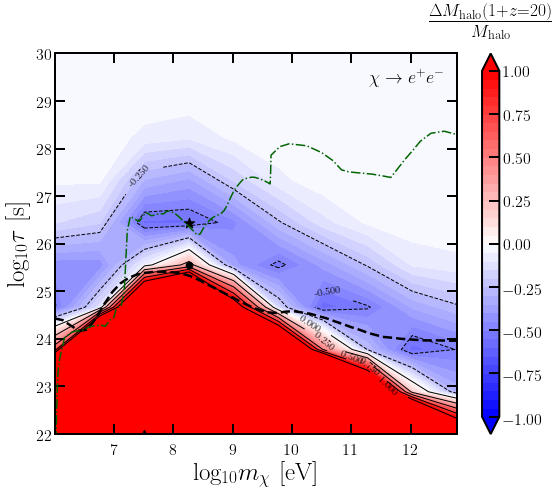

In [11]:
### Choose either T_vir or M_halo and the redshift to look at
rs_to_plot = 20
key_to_plot = 'M_halo'

fs_big = 25 #20
fs_small = 18

for pri in ['elec']: #, 'phot']:
    for inj_type in ['decay']: #, 'swave', 'pwave']:
        ### Load data and get lists of masses/injection parameters
        data_list = []
        dir_str = "/Users/viviesque/Dropbox (MIT)/H2 cooling/Data/collapse_data/"
        dir_LW = "/Users/viviesque/Dropbox (MIT)/H2 cooling/Data/collapse_LW/"

        directory = os.fsencode(dir_str)
        skip = 1

        mass_list_full = []
        inj_list_full = []

        # For every file in this directory
        for file in tqdm(sorted(os.listdir(directory))[::skip]): 
            filename = os.fsdecode(file)

            # Find the ones that match the channel specified above
            if (filename[13:17] == pri) and (filename[18:23] == inj_type):
                loaded = False
                try:
                    data_list.append(pickle.load(open(dir_str+filename, 'rb')))
                    loaded = True
                except: # HACKY WAY TO FILL IN MISSING FILES for decay/swave
                    if inj_type != 'pwave':
                        print("replacing with non-LW file...")
                        data_list.append(pickle.load(open(dir_str+filename, 'rb')))
                        loaded = True

                if loaded:
                    # Find the mass/injection parameter for each file
                    mass_str = filename[33:40]
                    if inj_type == 'decay':
                        if mass_str[0] == '1':
                            inj_param = float(filename[52:59])
                        else:
                            mass_str = mass_str[:-1]
                            inj_param = float(filename[51:58])
                    # If annihilation, save sigmav / mDM
                    else:
                        if mass_str[0] == '1':
                            inj_param = np.log10(10**float(filename[52:60]) / 10**float(mass_str))
                        else:
                            mass_str = mass_str[:-1]
                            inj_param = np.log10(10**float(filename[51:59]) / 10**float(mass_str))

                    mass_list_full = np.append(mass_list_full, float(mass_str))
                    inj_list_full = np.append(inj_list_full, inj_param)

        mass_list = np.sort(np.unique(mass_list_full))
        # inj_list = np.sort(np.unique(inj_list_full))

        print(f"# of files to plot: {len(data_list)}")

        # Alternate way to set mass_list and inj_list
        len_inj = 10 

        if inj_type == 'decay':
            inj_list = np.linspace(22, 30, num=len_inj) # lifetime
        elif inj_type == 'swave':
            inj_list = np.linspace(-38, -35, num=len_inj) # sigmav / mDM
        else:
            inj_list = np.linspace(-39, -25, num=len_inj) # sigmav / mDM
        
        ### Get quantity to plot
        res = H2.shooting_scheme([rs_to_plot], dists=LCDM_specs, H2_cool_rate='new', DM_switch=False)
        if key_to_plot == 'T_vir':
            cons_LCDM = res[key_to_plot]
        else:
            cons_LCDM = H2.M_given_T(rs_to_plot, res['T_vir'][0])

        # Find the same criterion for each dark matter model
        cons = np.zeros((len(mass_list), len(inj_list)))

        # For each data file, find the constraint quantity and
        #     match it to the correct mass and injection parameter
        for ii, datum in enumerate(data_list):
            mass_ind = np.argwhere(np.isclose(mass_list, mass_list_full[ii])) #np.argwhere(mass_list == mass_list_full[ii])
            inj_ind = np.argwhere(np.isclose(inj_list, inj_list_full[ii]))
            cons[mass_ind, inj_ind] = np.interp(rs_to_plot, datum['rs'][::-1], datum['T_vir'][::-1])
            if key_to_plot != 'T_vir':
                cons[mass_ind, inj_ind] = H2.M_given_T(rs_to_plot, cons[mass_ind, inj_ind])

        ### Plot constraint as a function of mass and injection parameter
        if pri=='phot':
            CMB_mass_list = np.linspace(4,12.8)
            CMB_mass_list = np.delete(CMB_mass_list, -3)

        else:
            CMB_mass_list = np.linspace(6,12.8)
        
        if inj_type == 'decay':
            cons_CMB = np.log10(param_bound(10**CMB_mass_list, inj_type, pri))
        elif inj_type == 'swave':
            cons_CMB = np.log10(param_bound(10**CMB_mass_list, inj_type, pri) / 10**CMB_mass_list)

        # Fill in any missing files (should be just pwave)
        inds_to_fill = np.argwhere(cons==0.)
        for inds in inds_to_fill:
            print('filling in missing data...')
            inj_ind_nzero = np.argwhere(cons[inds[0]] != 0.)
            if inj_type == 'decay':
                inj_ind_nzero = inj_ind_nzero[0]
            else:
                inj_ind_nzero = inj_ind_nzero[-1]
            cons[inds[0], inds[1]] = 2*cons[inds[0],inj_ind_nzero]

        # Choose levels to plot
        min_val = -1
        max_val = 1
        levels_less = np.linspace(min_val, max_val, num=9, endpoint=True)
        levels_more = np.linspace(min_val, max_val, num=41, endpoint=True)

        plt.figure(figsize=(9,7))
        ax = plt.gca()

        # For annihilation, use units of cm^3 / s / GeV
        scale_fac = 0
        if inj_type != 'decay':
            scale_fac = 9

        # Filled contours
        plt.contourf(mass_list, inj_list+scale_fac, np.transpose((cons - cons_LCDM) / cons_LCDM), 
                levels=levels_more, vmin=min_val, vmax=max_val, extend='both', cmap='bwr')
        clb = plt.colorbar(ticks=levels_less)
        clb.ax.set_title(r'$\frac{\Delta M_\mathrm{halo} (1+z=20)}{M_\mathrm{halo}}$', fontsize=fs_big)

        # Labelled line contours
        CS = plt.contour(mass_list, inj_list+scale_fac, np.transpose((cons - cons_LCDM) / cons_LCDM), 
                        levels=levels_less, vmin=min_val, vmax=max_val, extend='both', 
                        linewidths=1, colors='k')
        if inj_type != 'pwave':
            plt.plot(CMB_mass_list, cons_CMB+scale_fac, color='k', linestyle='--', label="CMB limits")
            if inj_type=='decay':
                if pri=='elec':
                    plt.plot(np.log10(telescope_decay[:,0]), np.log10(telescope_decay[:,1]),
                             color='darkgreen', linestyle='dashdot', linewidth=1.5, label='X/$\gamma$-ray Telescopes')
                else:
                    plt.plot(np.log10(decay_phot_masses), np.log10(decay_phot_limits(decay_phot_masses)), 
                             color='darkgreen', linestyle='dashdot', linewidth=1.5, label='X/$\gamma$-ray Telescopes')
        # elif pri=='elec':
        #     dirac_fac = 1/2
        #     plt.plot(np.log10(telescope_pwave[:,0]), 
        #              np.log10(telescope_pwave[:,1]*(1/2.2)**2 / (telescope_pwave[:,0])), 
        #              color='darkgreen', linestyle='dashdot', linewidth=1.5, label='X/$\gamma$-ray Telescopes')
        if pri=='elec' and inj_type=='decay':
            manual_locations = [(10.6, 25.), (7.8, 27.2), (10.3, 24.3), (10.6, 24.), (11, 23.6), (11.3, 23.4), (11.6, 23.)]
            ax.clabel(CS, CS.levels, manual=manual_locations)
        else:
            ax.clabel(CS, CS.levels)

        # Fiducial models
        if pri == 'elec' and inj_type == 'decay':
            plt.scatter([8.2667], [26.4444], marker='*', s=120, c='k')
            plt.scatter([8.2667], [25.5556], marker='.', s=180, c='k')

        plt.xlabel(r'log$_{10} m_\chi$ [eV]', fontsize=fs_big)
        if inj_type == 'decay':
            plt.ylabel(r'log$_{10} \tau$ [s]', fontsize=fs_big)
            if pri == 'phot':
                plt.text(0.81, 0.92, r'$\chi \rightarrow \gamma\gamma$', fontsize=fs_small, transform = ax.transAxes, 
                         bbox=dict(facecolor='white', alpha=0.8, linewidth=0))
            else:
                plt.text(0.78, 0.92, r'$\chi \rightarrow e^+ e^-$', fontsize=fs_small, transform = ax.transAxes)
        else:
            if inj_type == 'swave':
                plt.ylabel(r'log$_{10} \langle \sigma v \rangle / m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
            else:
                plt.ylabel(r'log$_{10} (\sigma v)_\mathrm{ref} / m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
            if pri == 'phot':
                plt.text(0.78, 0.92, r'$\chi\chi \rightarrow \gamma\gamma$', fontsize=fs_small, transform = ax.transAxes)
            else:
                plt.text(0.75, 0.92, r'$\chi\chi \rightarrow e^+ e^-$', fontsize=fs_small, transform = ax.transAxes)
        plt.xlim(np.min(mass_list), np.max(mass_list))
        if inj_type != 'pwave':
            plt.ylim(np.min(inj_list)+scale_fac, np.max(inj_list)+scale_fac)
        else:
            plt.ylim(-34+scale_fac, np.max(inj_list)+scale_fac)

        plt.savefig(fig_dir+'talk1.pdf')
        # plt.savefig(fig_dir+key_to_plot+f'_z{rs_to_plot}_'+pri+'_'+inj_type+'_levels.pdf')
        plt.show()

missing data point...
# of files to plot: 100


/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log10


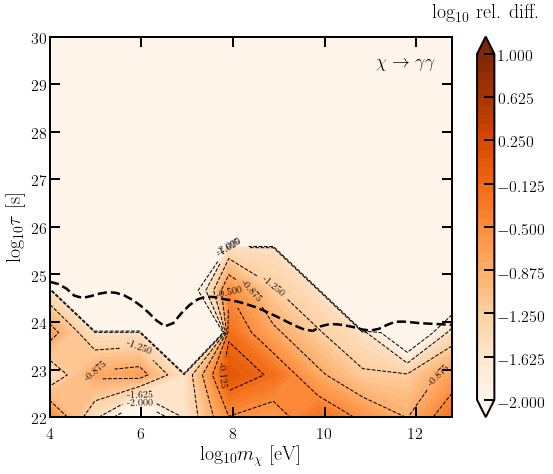

# of files to plot: 100


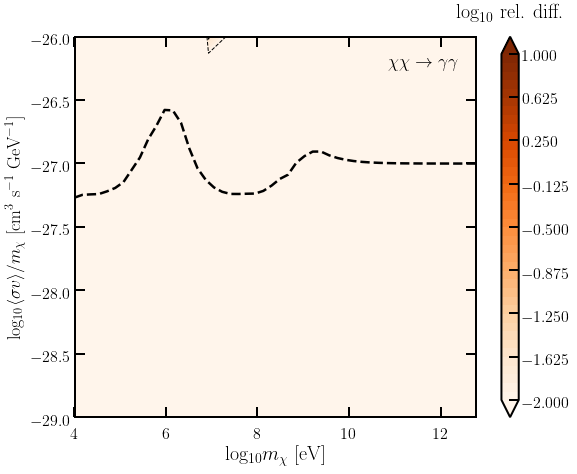

missing data point...
missing data point...
# of files to plot: 100


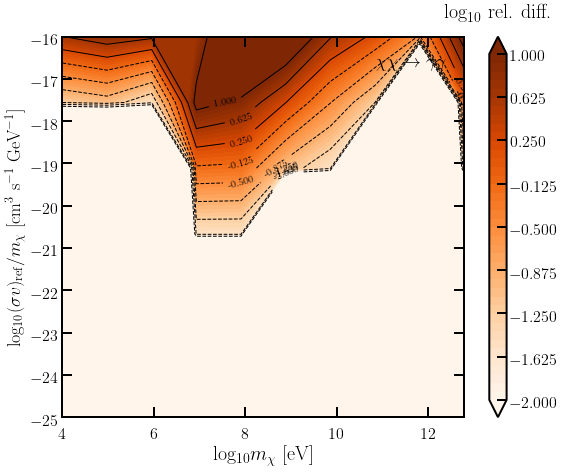

missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
# of files to plot: 100


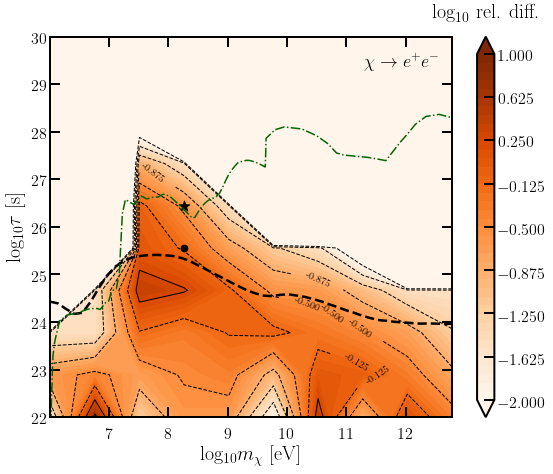

# of files to plot: 100


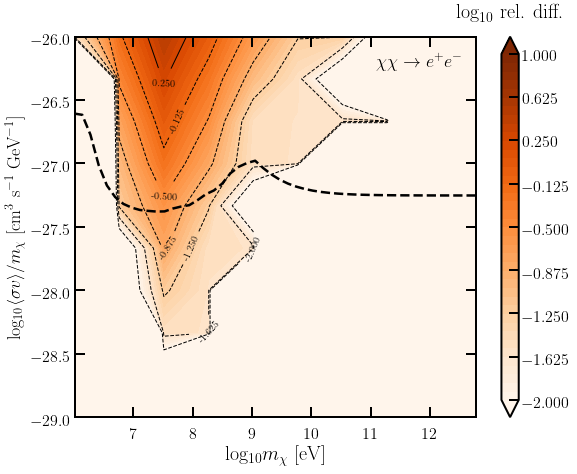

missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
missing data point...
# of files to plot: 100


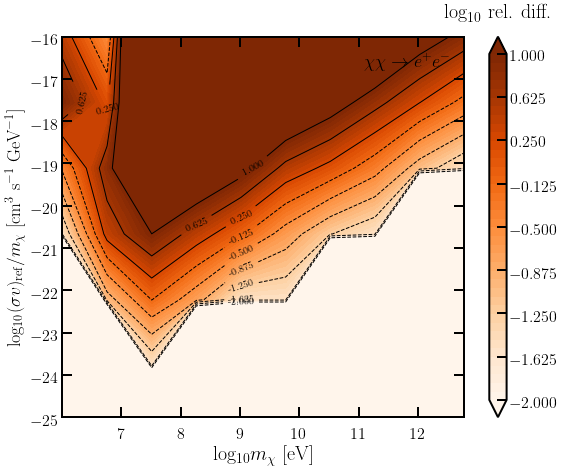

In [9]:
# Plot differences with and without LW background

### Choose either T_vir or M_halo and the redshift to look at
rs_to_plot = 20
key_to_plot = 'M_halo'

for pri in ['phot', 'elec']:
    for inj_type in ['decay', 'swave', 'pwave']:
        ### Load data and get lists of masses/injection parameters
        data_list = []
        data_list_LW = []
        dir_str = "/Users/viviesque/Dropbox (MIT)/H2 cooling/Data/collapse_data/"
        dir_LW = "/Users/viviesque/Dropbox (MIT)/H2 cooling/Data/collapse_LW/"

        directory = os.fsencode(dir_str)
        skip = 1

        mass_list_full = []
        inj_list_full = []
        loaded = []

        # For every file in this directory
        for file in tqdm(sorted(os.listdir(directory))[::skip]): 
            filename = os.fsdecode(file)
            # Find the ones that match the channel specified above
            if (filename[13:17] == pri) and (filename[18:23] == inj_type):
                data_list.append(pickle.load(open(dir_str+filename, 'rb')))
                try:
                    data_list_LW.append(pickle.load(open(dir_LW+filename, 'rb')))
                    loaded.append(True)
                except: # HACKY WAY TO DEAL WITH MISSING FILES
                    print("missing data point...")
                    data_list_LW.append(pickle.load(open(dir_str+filename, 'rb')))
                    loaded.append(False)

                # Find the mass/injection parameter for each file
                mass_str = filename[33:40]
                if inj_type == 'decay':
                    if mass_str[0] == '1':
                        inj_param = float(filename[52:59])
                    else:
                        mass_str = mass_str[:-1]
                        inj_param = float(filename[51:58])
                # If annihilation, save sigmav / mDM
                else:
                    if mass_str[0] == '1':
                        inj_param = np.log10(10**float(filename[52:60]) / 10**float(mass_str))
                    else:
                        mass_str = mass_str[:-1]
                        inj_param = np.log10(10**float(filename[51:59]) / 10**float(mass_str))

                mass_list_full = np.append(mass_list_full, float(mass_str))
                inj_list_full = np.append(inj_list_full, inj_param)
        
        mass_list = np.sort(np.unique(mass_list_full))
        # inj_list = np.sort(np.unique(inj_list_full))

        print(f"# of files to plot: {len(data_list)}")

        # Alternate way to set mass_list and inj_list
        len_inj = 10 

        if inj_type == 'decay':
            inj_list = np.linspace(22, 30, num=len_inj) # lifetime
        elif inj_type == 'swave':
            inj_list = np.linspace(-38, -35, num=len_inj) # sigmav / mDM
        else:
            inj_list = np.linspace(-39, -25, num=len_inj) # sigmav / mDM

        # Find the same criterion for each dark matter model
        cons = np.zeros((len(mass_list), len(inj_list)))
        loaded_box = np.zeros((len(mass_list), len(inj_list)), dtype='bool')

        # For each data file, find the constraint quantity and
        #     match it to the correct mass and injection parameter
        for ii, datum in enumerate(data_list):
            if loaded[ii]:
                mass_ind = np.argwhere(np.isclose(mass_list, mass_list_full[ii])) #np.argwhere(mass_list == mass_list_full[ii])
                inj_ind = np.argwhere(np.isclose(inj_list, inj_list_full[ii]))
                quant = np.interp(rs_to_plot, datum['rs'][::-1], datum['T_vir'][::-1])
                quant_LW = np.interp(rs_to_plot, data_list_LW[ii]['rs'][::-1], data_list_LW[ii]['T_vir'][::-1])
                if key_to_plot != 'T_vir':
                    quant = H2.M_given_T(rs_to_plot, quant)
                    quant_LW = H2.M_given_T(rs_to_plot, quant_LW)
                cons[mass_ind, inj_ind] = (quant_LW - quant) / quant
                loaded_box[mass_ind, inj_ind] = loaded[ii]
        cons = np.log10(abs(cons)) # log to make the differences easier to see

        # Extrapolate to fill in missing points
        if (pri == 'phot') and (inj_type=='decay'):
            for jj, inj in enumerate(inj_list):
                cons[~loaded_box[:,jj],jj] = interp1d(inj_list[loaded_box[:,jj]], cons[loaded_box[:,jj],jj])(inj_list[~loaded_box[:,jj]])
        else:
            for ii, mass in enumerate(mass_list):
                cons[ii,~loaded_box[ii]] = interp1d(mass_list[loaded_box[ii]], cons[ii,loaded_box[ii]], fill_value='extrapolate')(mass_list[~loaded_box[ii]])

        ### Plot constraint as a function of mass and injection parameter
        if pri=='phot':
            CMB_mass_list = np.linspace(4,12.8)
            CMB_mass_list = np.delete(CMB_mass_list, -3)

        else:
            CMB_mass_list = np.linspace(6,12.8)
        
        if inj_type == 'decay':
            cons_CMB = np.log10(param_bound(10**CMB_mass_list, inj_type, pri))
        elif inj_type == 'swave':
            cons_CMB = np.log10(param_bound(10**CMB_mass_list, inj_type, pri) / 10**CMB_mass_list)

        # Choose levels to plot
        min_val = -2
        max_val = 1
        levels_less = np.linspace(min_val, max_val, num=9, endpoint=True)
        levels_more = np.linspace(min_val, max_val, num=41, endpoint=True)

        plt.figure(figsize=(9,7))
        ax = plt.gca()

        # For annihilation, use units of cm^3 / s / GeV
        scale_fac = 0
        if inj_type != 'decay':
            scale_fac = 9

        # Filled contours
        plt.contourf(mass_list, inj_list+scale_fac, np.transpose(cons), 
                levels=levels_more, vmin=min_val, vmax=max_val, extend='both', cmap='Oranges')
        clb = plt.colorbar(ticks=levels_less)
        clb.ax.set_title(r'$\log_{10}$ rel. diff.', fontsize=20)

        # Labelled line contours
        CS = plt.contour(mass_list, inj_list+scale_fac, np.transpose(cons), 
                        levels=levels_less, vmin=min_val, vmax=max_val, extend='both', 
                        linewidths=1, colors='k')
        if inj_type != 'pwave':
            plt.plot(CMB_mass_list, cons_CMB+scale_fac, color='k', linestyle='--', label="CMB limits")
            if inj_type=='decay' and pri=='elec':
                # plt.plot(np.log10(np.insert(voyagerDecay[:,0], 0, 1.253e7)), 
                #          np.log10(np.insert(voyagerDecay[:,1], 0, 1e21)),
                #          color='darkblue', linestyle=':', linewidth=1.5, label='Voyager I')
                plt.plot(np.log10(telescope_decay[:,0]), 
                         np.log10(telescope_decay[:,1]),
                         color='darkgreen', linestyle='dashdot', linewidth=1.5, label='X/$\gamma$-ray Telescopes')
            
        if pri=='elec' and inj_type=='decay':
            manual_locations = [(10.6, 25.), (7.8, 27.2), (10.3, 24.3), (10.6, 24.), (11, 23.6), (11.3, 23.4), (11.6, 23.)]
            ax.clabel(CS, CS.levels, manual=manual_locations)
        else:
            ax.clabel(CS, CS.levels)

        # Fiducial models
        if pri == 'elec' and inj_type == 'decay':
            plt.scatter([8.2667], [26.4444], marker='*', s=120, c='k')
            plt.scatter([8.2667], [25.5556], marker='.', s=180, c='k')

        plt.xlabel(r'log$_{10} m_\chi$ [eV]', fontsize=20)
        if inj_type == 'decay':
            plt.ylabel(r'log$_{10} \tau$ [s]', fontsize=20)
            if pri == 'phot':
                plt.text(0.81, 0.92, r'$\chi \rightarrow \gamma\gamma$', fontsize=18, transform = ax.transAxes)
            else:
                plt.text(0.78, 0.92, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
        else:
            if inj_type == 'swave':
                plt.ylabel(r'log$_{10} \langle \sigma v \rangle / m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
            else:
                plt.ylabel(r'log$_{10} (\sigma v)_\mathrm{ref} / m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
            if pri == 'phot':
                plt.text(0.78, 0.92, r'$\chi\chi \rightarrow \gamma\gamma$', fontsize=18, transform = ax.transAxes)
            else:
                plt.text(0.75, 0.92, r'$\chi\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
        plt.xlim(np.min(mass_list), np.max(mass_list))
        if inj_type != 'pwave':
            plt.ylim(np.min(inj_list)+scale_fac, np.max(inj_list)+scale_fac)
        else:
            plt.ylim(-34+scale_fac, np.max(inj_list)+scale_fac)

        plt.savefig(fig_dir+key_to_plot+f'_z{rs_to_plot}_'+pri+'_'+inj_type+'_diffs.pdf')
        plt.show()

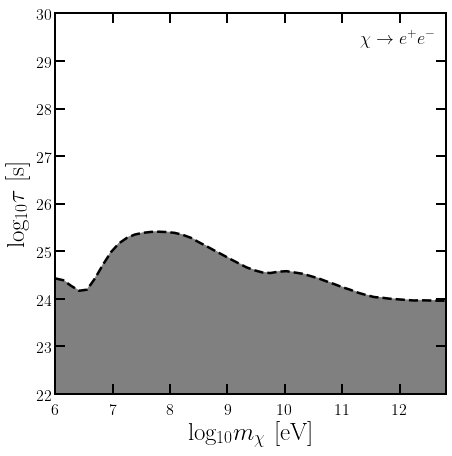

In [ ]:
pri = 'elec'
inj_type = 'decay'
mass_list = np.linspace(6,12.8)

### Plot constraint as a function of mass and injection parameter
if inj_type == 'decay':
    cons_CMB = np.log10(param_bound(10**mass_list, inj_type, pri))
elif inj_type == 'swave':
    cons_CMB = np.log10(param_bound(10**mass_list, inj_type, pri) / 10**mass_list)

plt.figure(figsize=(7,7))
ax = plt.gca()

plt.fill_between(mass_list, cons_CMB, 0, color='grey')
plt.plot(mass_list, cons_CMB, color='k', linestyle='--', label="CMB limits")

plt.xlabel(r'log$_{10} m_\chi$ [eV]', fontsize=25)
plt.ylabel(r'log$_{10} \tau$ [s]', fontsize=25)
plt.text(0.78, 0.92, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)

plt.axis([6,12.8,22,30])
plt.savefig(fig_dir+'talk2.pdf')
plt.show()

# Validation of results: Plot IGM temperature at 1+z=20 over this parameter space

In [ ]:
TIGM_LCDM = phys.Tm_std(rs=20)
print(f"In LCDM, T_IGM (1+z = 20) = {TIGM_LCDM / phys.kB:.2f} K")

In LCDM, T_IGM (1+z = 20) = 8.46 K


In [ ]:
%autoreload
mDM_list = np.linspace(6, 12.8, num=30)
inj_list = np.linspace(22, 30, num=20)
rs_vec = np.flipud(np.arange(5, 3000, 0.1))

TIGM_arr = np.zeros((30,20))

for ii, mDM in enumerate(tqdm(10**mDM_list)):
    for jj, inj_par in enumerate(10**inj_list):
        res = tla.get_history(
            rs_vec, baseline_f=True, 
            DM_process='decay', inj_particle='elec',
            mDM=mDM, lifetime=inj_par,
        )
        TIGM_arr[ii,jj] = np.interp(20, np.flipud(rs_vec), np.flipud(res[:,0]))

../config.py:379: RuntimeWarning: divide by zero encountered in log
  ) for label in labels}
../config.py:379: RuntimeWarning: invalid value encountered in log
  ) for label in labels}
/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

In [ ]:
min_val = 0.5
max_val = 4.5
levels_less = np.linspace(min_val, max_val, num=9, endpoint=True)
levels_more = np.linspace(min_val, max_val, num=41, endpoint=True)

plt.figure(figsize=(9,7))
ax = plt.gca()

# Filled contours
plt.contourf(mDM_list, inj_list, np.transpose(np.log10(TIGM_arr / phys.kB)), 
        levels=levels_more, vmin=min_val, vmax=max_val, 
        extend='both', cmap='plasma')
clb = plt.colorbar(ticks=levels_less)
clb.ax.set_title(r'$\log_{10} T_\mathrm{IGM} (z=20)$ [K]', fontsize=16)

# Labelled line contours
CS = plt.contour(mDM_list, inj_list, np.transpose(np.log10(TIGM_arr / phys.kB)), 
                levels=levels_less, vmin=min_val, vmax=max_val, extend='both', 
                linewidths=1, colors='k')
CS_bold = plt.contour(mDM_list, inj_list, np.transpose(np.log10(TIGM_arr / phys.kB)), 
                levels=[np.log10(2e3)], linewidths=3, colors='k')
ax.clabel(CS, CS.levels)
ax.clabel(CS_bold, CS_bold.levels)

plt.xlabel(r'log$_{10} m_\chi$ [eV]')
plt.ylabel(r'log$_{10} \tau$ [s]')
plt.xlim(np.min(mDM_list), np.max(mDM_list))

plt.show()

NameError: name 'np' is not defined

# Make a GIF version

# of files to plot: 100


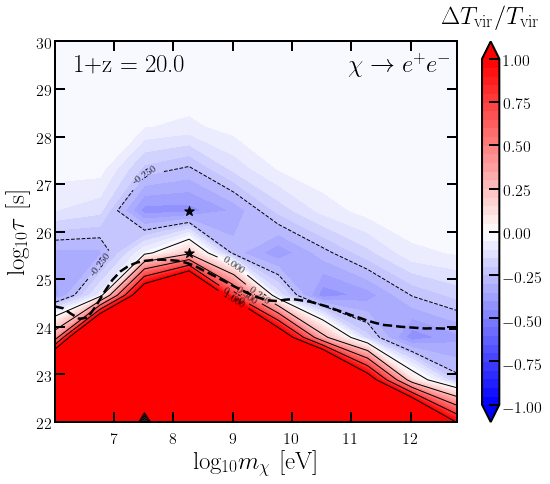

# of files to plot: 100


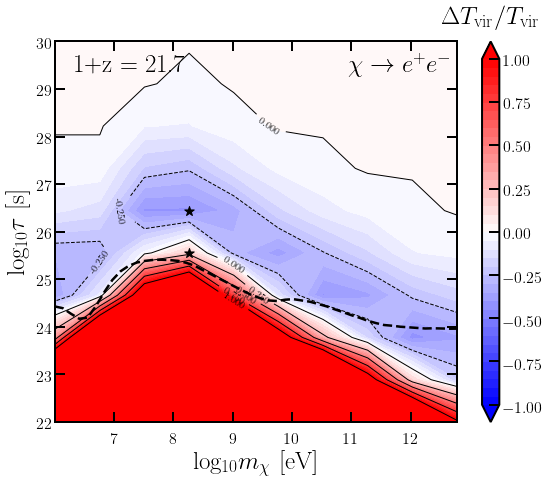

# of files to plot: 100


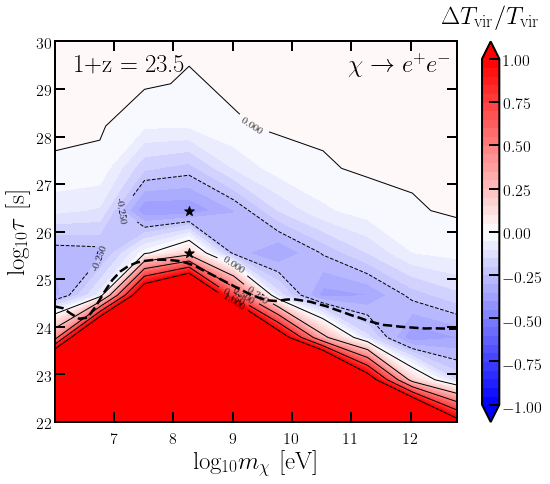

# of files to plot: 100


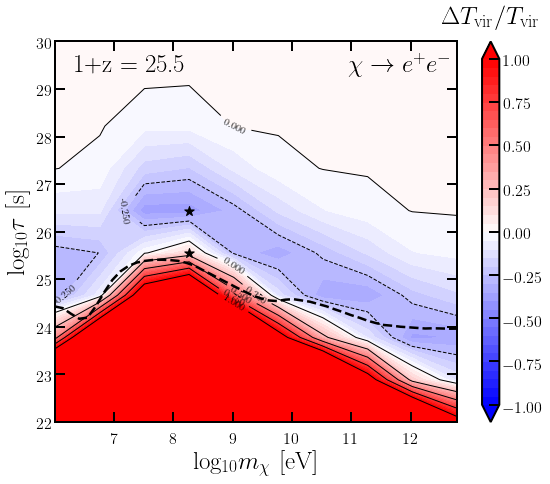

# of files to plot: 100


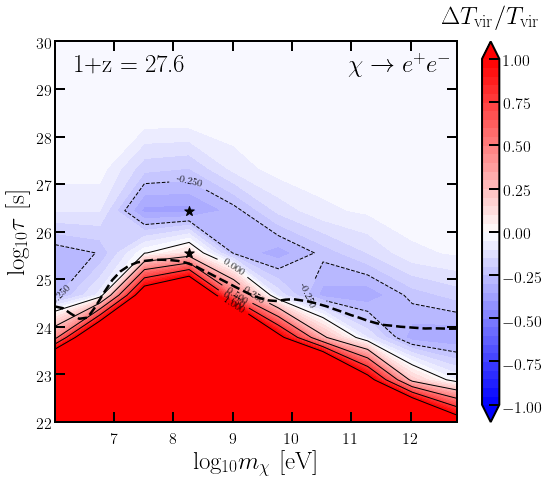

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:589: RuntimeWarning: overflow encountered in exp
  * np.exp(-rydberg/4/T_rad) * alpha_recomb(T_rad, 'HI', fudge=fudge)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in e

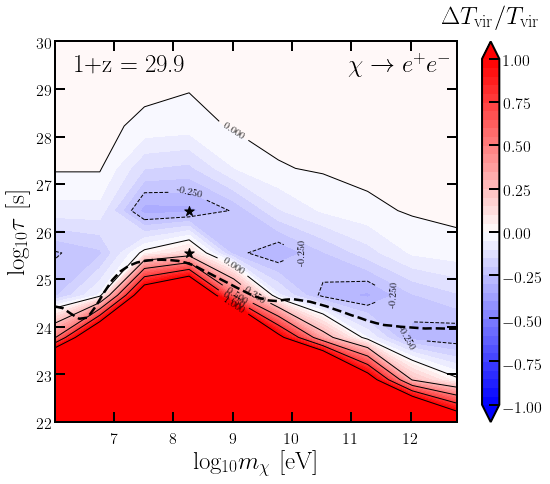

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:589: RuntimeWarning: overflow encountered in exp
  * np.exp(-rydberg/4/T_rad) * alpha_recomb(T_rad, 'HI', fudge=fudge)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in e

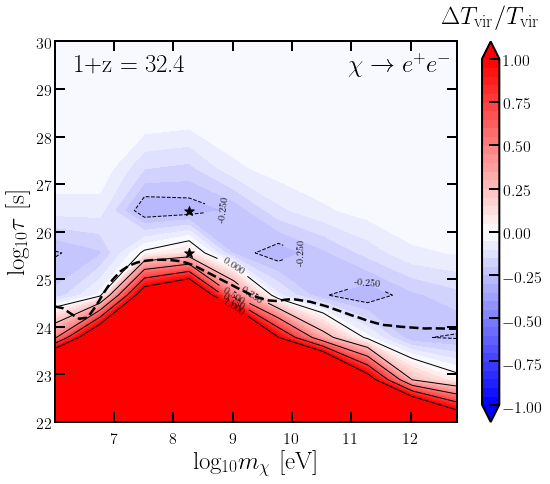

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:589: RuntimeWarning: overflow encountered in exp
  * np.exp(-rydberg/4/T_rad) * alpha_recomb(T_rad, 'HI', fudge=fudge)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in e

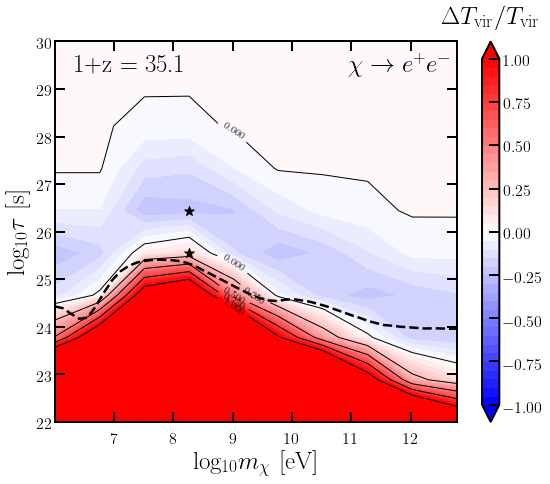

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:589: RuntimeWarning: overflow encountered in exp
  * np.exp(-rydberg/4/T_rad) * alpha_recomb(T_rad, 'HI', fudge=fudge)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in e

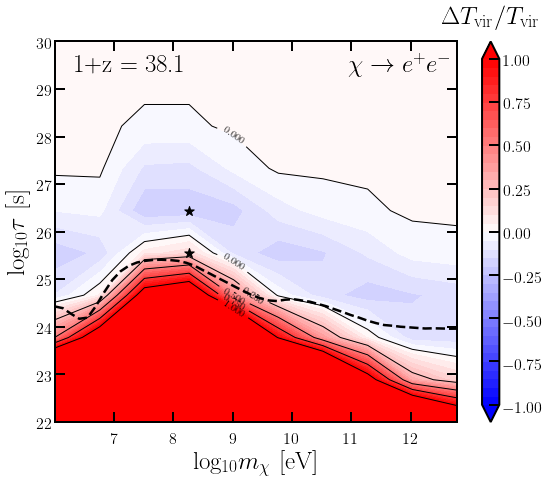

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in exp
  * np.exp(-phys.lya_eng/phys.TCMB(rs))
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHist

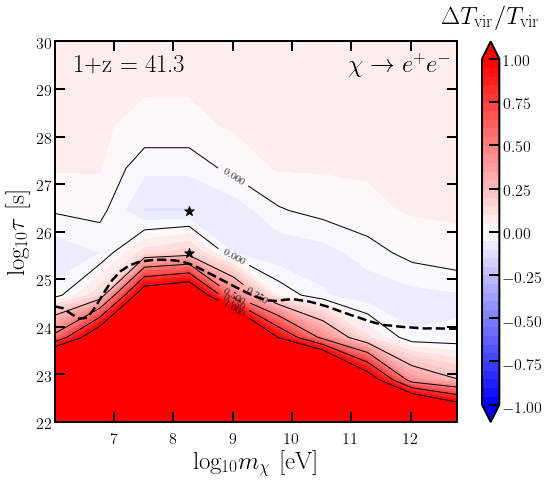

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in exp
  * np.exp(-phys.lya_eng/phys.TCMB(rs))
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHist

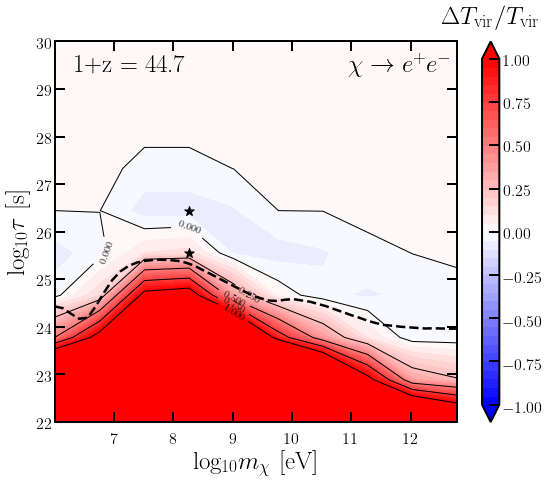

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:186: RuntimeWarning: overflow encountered in exp
  * np.exp(-phys.lya_eng/phys.TCMB(rs))
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHist

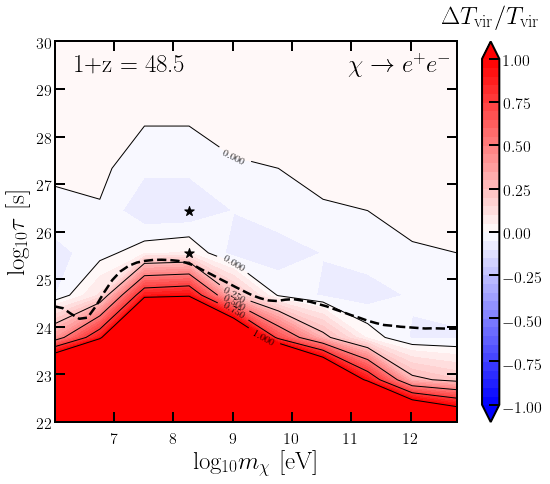

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


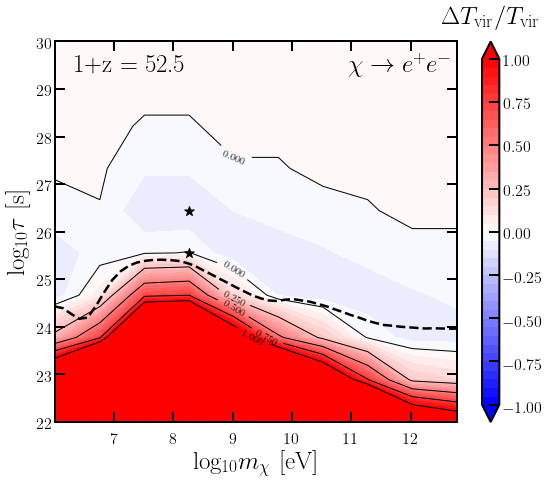

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


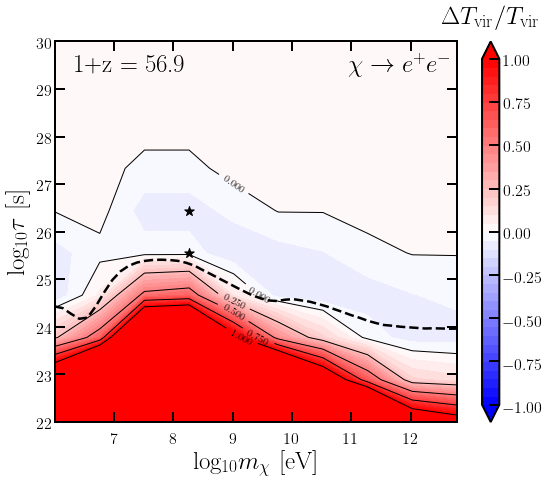

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


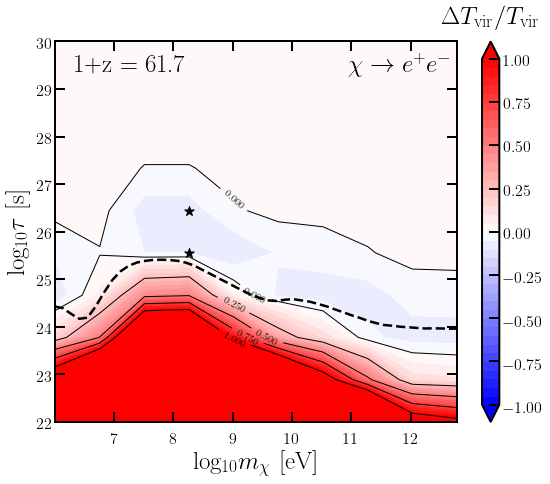

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


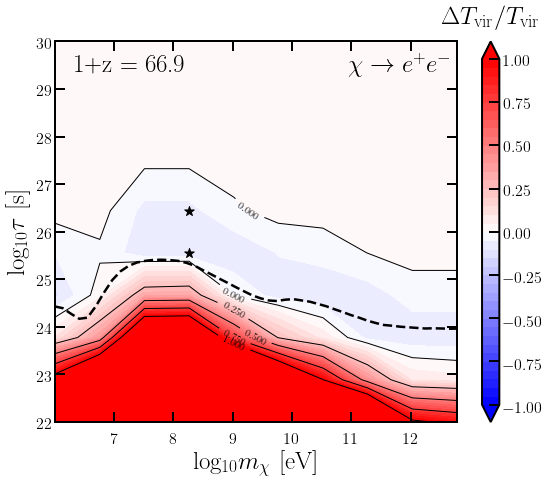

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


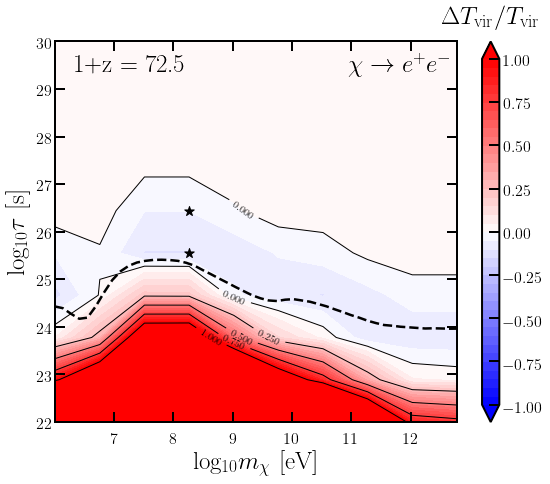

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


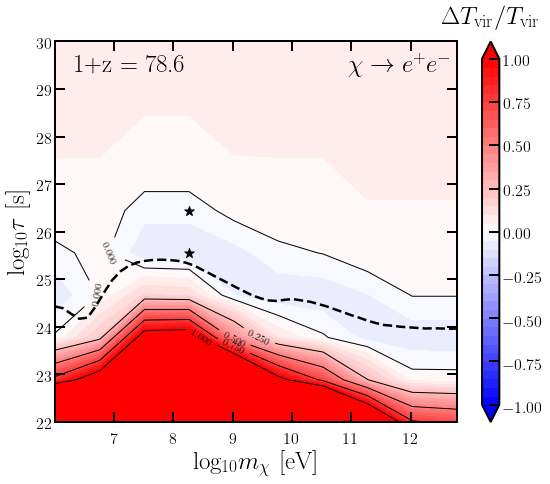

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


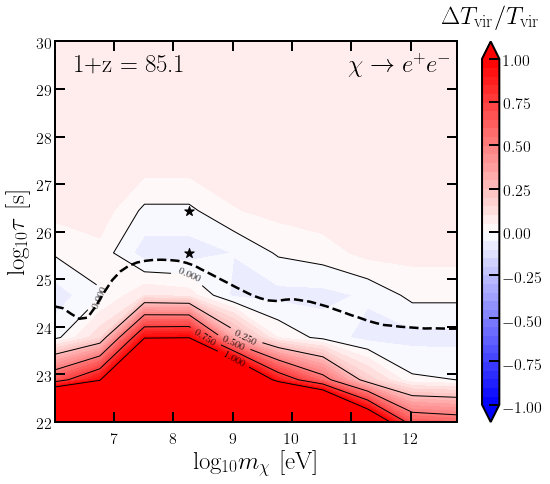

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


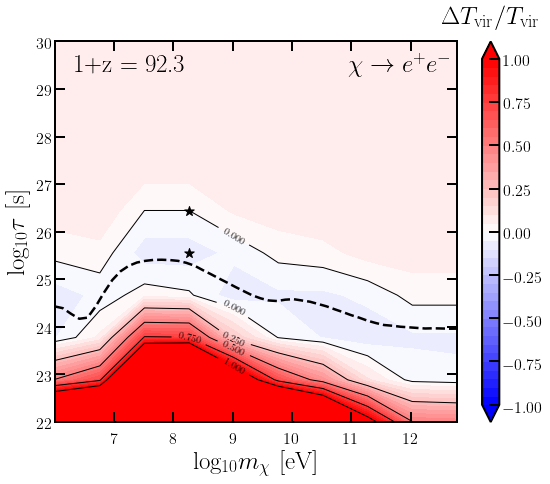

# of files to plot: 100


../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:583: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * mu_ep * T_rad)
../darkhistory/physics.py:526: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


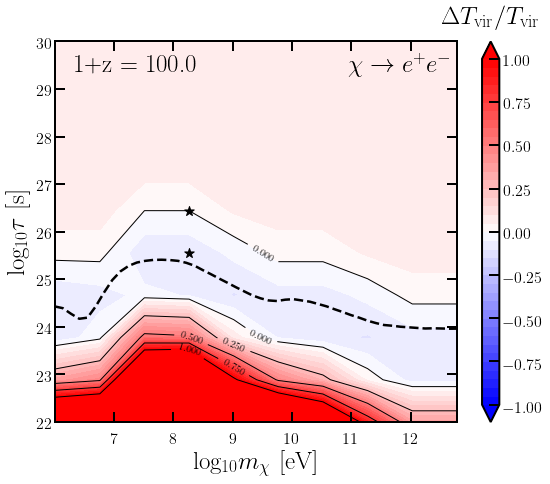

In [ ]:
### Choose either T_vir or M_halo and the redshift to look at
rs_plot_list = np.logspace(np.log10(20), 2, num=21) #[20]
key_to_plot = 'M_halo'

# ### Package distortions together
# LCDM_specs = no_DM['data'][-1]['distortions'].copy()
# for ii, rs in enumerate(no_DM['data'][-1]['rs']):
#     temp_dist = no_DM['data'][-1]['distortions'].copy()
#     temp_dist.redshift(rs)
#     weights = np.zeros_like(no_DM['data'][-1]['rs'])
#     weights[:ii] = 1
#     LCDM_specs[ii] = temp_dist.sum_specs(weight=weights)

for rs_to_plot in tqdm(rs_plot_list):
    for pri in ['elec']: #['phot', 'elec']:
        for inj_type in ['decay']: #, 'swave', 'pwave']:
            ### Load data and get lists of masses/injection parameters
            data_list = []
            dir_str = "/Users/viviesque/Dropbox (MIT)/H2 cooling/Data/collapse_data/"

            directory = os.fsencode(dir_str)
            skip = 1

            mass_list_full = []
            inj_list_full = []

            # For every file in this directory
            for file in sorted(os.listdir(directory))[::skip]: 
                filename = os.fsdecode(file)

                # Find the ones that match the channel specified above
                if (filename[13:17] == pri) and (filename[18:23] == inj_type):
                    data_list.append(pickle.load(open(dir_str+filename, 'rb')))

                    # Find the mass/injection parameter for each file
                    mass_str = filename[33:40]
                    if inj_type == 'decay':
                        if mass_str[0] == '1':
                            inj_param = float(filename[52:59])
                        else:
                            mass_str = mass_str[:-1]
                            inj_param = float(filename[51:58])
                    # If annihilation, save sigmav / mDM
                    else:
                        if mass_str[0] == '1':
                            inj_param = np.log10(10**float(filename[52:60]) / 10**float(mass_str))
                        else:
                            mass_str = mass_str[:-1]
                            inj_param = np.log10(10**float(filename[51:59]) / 10**float(mass_str))

                    mass_list_full = np.append(mass_list_full, float(mass_str))
                    inj_list_full = np.append(inj_list_full, inj_param)

            mass_list = np.sort(np.unique(mass_list_full))
            inj_list = np.sort(np.unique(inj_list_full))

            print(f"# of files to plot: {len(data_list)}")

            # Alternate way to set inj_list
            len_inj = 10 

            if inj_type == 'decay':
                inj_list = np.linspace(22, 30, num=len_inj) # lifetime
            elif inj_type == 'swave':
                inj_list = np.linspace(-38, -35, num=len_inj) # sigmav / mDM
            else:
                inj_list = np.linspace(-39, -25, num=len_inj) # sigmav / mDM

            ### Get quantity to plot
            res = H2.shooting_scheme([rs_to_plot], dists=LCDM_specs, H2_cool_rate='new', DM_switch=False)
            cons_LCDM = res[key_to_plot]

            # Find the same criterion for each dark matter model
            cons = np.zeros((len(mass_list), len(inj_list)))

            # For each data file, find the constraint quantity and
            #     match it to the correct mass and injection parameter
            for ii, datum in enumerate(data_list):
                mass_ind = np.argwhere(mass_list == mass_list_full[ii])
                inj_ind = np.argwhere(np.isclose(inj_list, inj_list_full[ii]))
                cons[mass_ind, inj_ind] = np.interp(rs_to_plot, datum['rs'][::-1], datum[key_to_plot][::-1])


            ### Plot constraint as a function of mass and injection parameter
            if pri=='phot':
                CMB_mass_list = np.linspace(4,12.8)
                CMB_mass_list = np.delete(CMB_mass_list, -3)

            else:
                CMB_mass_list = np.linspace(6,12.8)
            
            if inj_type == 'decay':
                cons_CMB = np.log10(param_bound(10**CMB_mass_list, inj_type, pri))
            elif inj_type == 'swave':
                cons_CMB = np.log10(param_bound(10**CMB_mass_list, inj_type, pri) / 10**CMB_mass_list)

            # Choose levels to plot
            min_val = -1
            max_val = 1
            levels_less = np.linspace(min_val, max_val, num=9, endpoint=True)
            levels_more = np.linspace(min_val, max_val, num=41, endpoint=True)

            plt.figure(figsize=(9,7))
            ax = plt.gca()

            # Filled contours
            plt.contourf(mass_list, inj_list, np.transpose((cons - cons_LCDM) / cons_LCDM), 
                    levels=levels_more, vmin=min_val, vmax=max_val, extend='both', cmap='bwr')
            clb = plt.colorbar(ticks=levels_less)
            clb.ax.set_title(r'$\Delta T_\mathrm{vir}/T_\mathrm{vir}$', fontsize=25)

            # Labelled line contours
            CS = plt.contour(mass_list, inj_list, np.transpose((cons - cons_LCDM) / cons_LCDM), 
                            levels=levels_less, vmin=min_val, vmax=max_val, extend='both', 
                            linewidths=1, colors='k')
            if inj_type != 'pwave':
                plt.plot(CMB_mass_list, cons_CMB, color='k', linestyle='--', label="CMB limits")
            elif pri=='elec':
                dirac_fac = 1/2
                plt.plot(np.log10(np.insert(voyager_conservative[:,0], 0, 3.66e6)), 
                        np.log10(np.insert(dirac_fac*voyager_conservative[:,1]*(1e7/phys.c)**(2), 0, 1e-27) / (np.insert(voyager_conservative[:,0], 0, 3.66e6))), 
                        color='k', linestyle=':', label='Voyager I')
                plt.plot(np.log10(telescope_pwave[:,0]), 
                        np.log10(telescope_pwave[:,1]*(1/2.2)**2 / (telescope_pwave[:,0])), 
                        color='k', linestyle='dashdot', label='X/$\gamma$-ray Telescopes')
                # plt.plot(np.log10(dsph_pwave[:,0]), 
                #          np.log10(dsph_pwave[:,1] / (dsph_pwave[:,0])), 
                #          color='red', linestyle='dashdot', label='Dwarf Galaxies')
                plt.plot(np.log10(Cirelli_et_al[:,0]*1e6), 
                        np.log10(Cirelli_et_al[:,1]*(1/2.2)**2 / (Cirelli_et_al[:,0]*1e6)), 
                        color='k', linestyle='--', linewidth=1.2, label='INTEGRAL')
            ax.clabel(CS, CS.levels)

            # Fiducial models
            if pri == 'elec' and inj_type == 'decay':
                plt.scatter([8.2667, 8.2667], [25.5556, 26.4444], marker='*', s=100, c='k')

            plt.xlabel(r'log$_{10} m_\chi$ [eV]', fontsize=25)
            if inj_type == 'decay':
                plt.ylabel(r'log$_{10} \tau$ [s]', fontsize=25)
                if pri == 'phot':
                    plt.text(0.76, 0.92, r'$\chi \rightarrow \gamma\gamma$', fontsize=25, transform = ax.transAxes)
                else:
                    plt.text(0.73, 0.92, r'$\chi \rightarrow e^+ e^-$', fontsize=25, transform = ax.transAxes)
            else:
                if inj_type == 'swave':
                    plt.ylabel(r'log$_{10} \langle \sigma v \rangle / m_\chi$ [cm$^3$ s$^{-1}$ eV$^{-1}$]')
                else:
                    plt.ylabel(r'log$_{10} (\sigma v)_\mathrm{ref} / m_\chi$ [cm$^3$ s$^{-1}$ eV$^{-1}$]')
                if pri == 'phot':
                    plt.text(0.72, 0.92, r'$\chi\chi \rightarrow \gamma\gamma$', fontsize=25, transform = ax.transAxes)
                else:
                    plt.text(0.69, 0.92, r'$\chi\chi \rightarrow e^+ e^-$', fontsize=25, transform = ax.transAxes)
            plt.text(0.05, 0.92, rf"1+z = {rs_to_plot:.1f}", fontsize=25, transform = ax.transAxes)
            plt.xlim(np.min(mass_list), np.max(mass_list))

            plt.savefig(fig_dir+'gif/'+key_to_plot+f'_z{rs_to_plot:.1f}_'+pri+'_'+inj_type+'_levels.png')
            plt.show()